In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import numpy as np
import os

## Sentiment Analysis - Masking

### loading IMDb reviews using TensorFlow Datasets

In [3]:
#downloading dataset imdb_reviews to C:\Users\josef\tensorflow_datasets\imdb_reviews\...

In [4]:
import tensorflow_datasets as tfds

train_ds, info_train = tfds.load('imdb_reviews', split='train[:80%]', as_supervised=True, with_info=True)
val_ds, info_val = tfds.load('imdb_reviews', split='train[-20%:]', as_supervised=True, with_info=True)

In [5]:
train_size = info_train.splits["train[:80%]"].num_examples; train_size

20000

In [6]:
val_size = info_val.splits["train[-20%:]"].num_examples; val_size

5000

In [7]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)   #restrict string to 300 characters
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")   #replace "<br />" or "<br >" with repeated space
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")   #replace everything not a letter or apostrophe
    X_batch = tf.strings.split(X_batch)  #split string into words
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch  #include padding for overall batch

In [8]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in train_ds.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [9]:
vocabulary.most_common()[:3]

[(b'<pad>', 171811), (b'the', 48816), (b'a', 30677)]

In [10]:
len(vocabulary)

48238

In [11]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [12]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [13]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [14]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [15]:
train_set = train_ds.repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

val_set = val_ds.repeat().batch(32).map(preprocess)
val_set = val_set.map(encode_words).prefetch(1)

### training recurrent network: stacked GRU

In [16]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch=train_size // 32, 
                    epochs=10, 
                    validation_data=val_set,
                    validation_steps=val_size // 32 )

Epoch 1/10
625/625 [==============================] - 452s 723ms/step - loss: 0.5685 - accuracy: 0.6953 - val_loss: 0.4840 - val_accuracy: 0.7817
Epoch 2/10
625/625 [==============================] - 558s 893ms/step - loss: 0.3641 - accuracy: 0.8466 - val_loss: 0.4767 - val_accuracy: 0.7855
Epoch 3/10
625/625 [==============================] - 568s 908ms/step - loss: 0.1835 - accuracy: 0.9331 - val_loss: 0.6828 - val_accuracy: 0.7648
Epoch 4/10
625/625 [==============================] - 572s 914ms/step - loss: 0.1190 - accuracy: 0.9587 - val_loss: 0.7491 - val_accuracy: 0.7526
Epoch 5/10
625/625 [==============================] - 602s 963ms/step - loss: 0.1053 - accuracy: 0.9610 - val_loss: 0.7846 - val_accuracy: 0.7514
Epoch 6/10
625/625 [==============================] - 568s 909ms/step - loss: 0.0945 - accuracy: 0.9649 - val_loss: 0.8757 - val_accuracy: 0.7616
Epoch 7/10
625/625 [==============================] - 551s 882ms/step - loss: 0.0773 - accuracy: 0.9717 - val_loss: 1.0166 -

### evaluating model

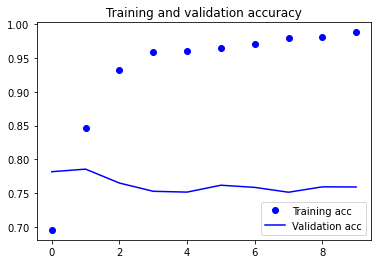

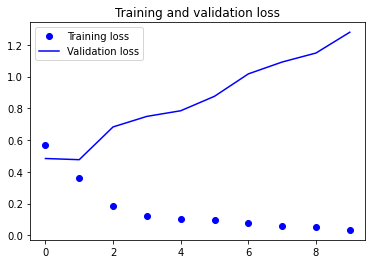

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
import numpy as np
np.argmax(val_acc)+1

2

In [19]:
round(val_acc[np.argmax(val_acc)],2)

0.79